<a href="https://colab.research.google.com/github/ramreddy-physics/Portfolio-Optimization-Notebooks/blob/main/predictive_weights_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import yfinance as yf
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:

tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NVDA', 'DAL', 'V', 'GE', 'SPGI', 'MU']
data = yf.download(tickers,'2016-01-01','2023-07-01')
data = data['Open'].values

[*********************100%%**********************]  10 of 10 completed


In [ ]:
data = np.log10(data/data[0, :])
data = torch.tensor(data, dtype=torch.float32, device = device)

In [ ]:
data_np = data.cpu().detach().numpy()

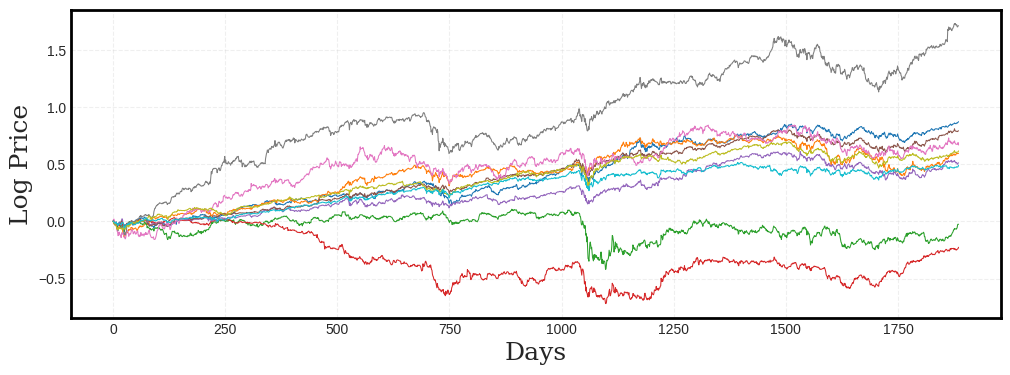

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
cmap = plt.get_cmap('tab10')
for i in range(data.shape[1]):
    ax.plot(data_np[:, i], lw=0.75, color=cmap(i/data.shape[1]))
ax.grid(True, ls='--', alpha=0.3)
ax.set_xlabel('Days', fontsize = 18, fontfamily = 'serif')
ax.set_ylabel('Log Price', fontsize = 18, fontfamily = 'serif')
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('k')
plt.show()

In [ ]:
test_size = 750
train_set = data[:-test_size]
test_set = data[-test_size:]

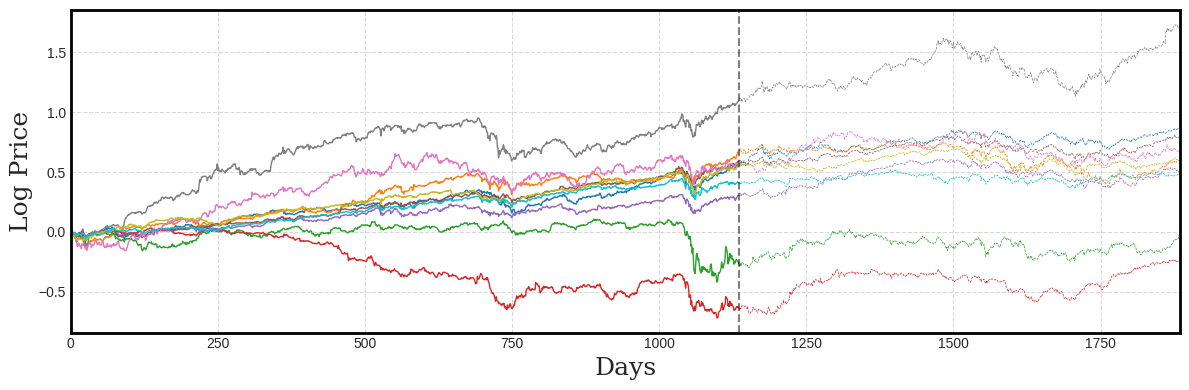

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ts = np.arange(data.shape[0])
for i in range(data.shape[1]):
    line=ax.plot(ts[:-test_size], data_np[:-test_size, i], lw=1.00, color=cmap(i/data.shape[1]))
    ax.plot(ts[-test_size:], data_np[-test_size:, i], lw=0.50, color=cmap(i/data.shape[1]), ls='--')
    ''' if tickers[i] == 'GE':
        line[0].set_label('GE')
        line[0].set_linewidth(1.5)
        line[0].set_color('b') '''

ax.axvline(x=data.shape[0]-test_size, c='k', ls='--', alpha=0.5)

ax.grid(True, ls='--', alpha=0.75)
ax.set_xlabel('Days', fontsize = 18, fontfamily = 'serif')
ax.set_ylabel('Log Price', fontsize = 18, fontfamily = 'serif')
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('k')

ax.set_xlim([0, data.shape[0]-1])

#ax.legend(frameon=False, fontsize=12)

plt.tight_layout()

plt.savefig('/content/gdrive/MyDrive/Portfolio Optimization/LSTM_data.png', dpi=300)

plt.show()

In [ ]:
def input_data(seq, ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        window = (window - window[0])[1:]
        label = seq[i+ws:i+ws+1] - seq[i+ws-1:i+ws]
        out.append((window,label))
    return out

In [ ]:
window_size = 10
train_data = input_data(train_set, window_size)
inputs, labels = zip(*train_data)
inputs_tensor = torch.stack(inputs)
labels_tensor = torch.stack(labels)
train_data = TensorDataset(inputs_tensor, labels_tensor)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sigmoid = nn.Sigmoid()

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))  # out: tensor of shape (N_batch, N_seq, hidden_size)

        # Take the last hidden state
        out = hn[-1]  # out: tensor of shape (N_batch, hidden_size)

        # Pass the last hidden state through the fully connected layer
        out = self.fc(out)  # out: tensor of shape (N_batch, N_output)

        return self.sigmoid(out)
        #return out

In [ ]:
torch.manual_seed(20)
hidden_size=32
num_layers=2
model = LSTMModel(input_size=10, hidden_size=hidden_size, output_size=10, num_layers=num_layers).to(device)

In [ ]:
loss_list=[]

def criterion(w, labels):
    w = w/w.sum()
    return -torch.sum(w*(10.0**labels))

In [ ]:
epochs = 1000

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

best_loss = np.inf
model.train()
for i in range(epochs):
    total_loss = 0
    for batch_idx, (input_batch, label_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(input_batch)
        loss = criterion(y_pred, label_batch)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        total_loss += loss.item()

    total_loss /= len(train_loader)
    loss_list.append(total_loss)
    if total_loss < best_loss:
        best_loss = total_loss
        torch.save(model.state_dict(), "/content/gdrive/MyDrive/Portfolio Optimization/LSTM_weights_2.pt")

    if (i+1)%100 == 0:
        print(f"Epoch {i+1} Loss: {total_loss}")

Epoch 100 Loss: -15.883156077962527
Epoch 200 Loss: -15.888384322045555
Epoch 300 Loss: -15.901922084915807
Epoch 400 Loss: -15.903598234687053
Epoch 500 Loss: -15.903796061663561
Epoch 600 Loss: -15.903869346833565
Epoch 700 Loss: -15.903906708032313
Epoch 800 Loss: -15.903929837992493
Epoch 900 Loss: -15.903944693820577
Epoch 1000 Loss: -15.90395590956782


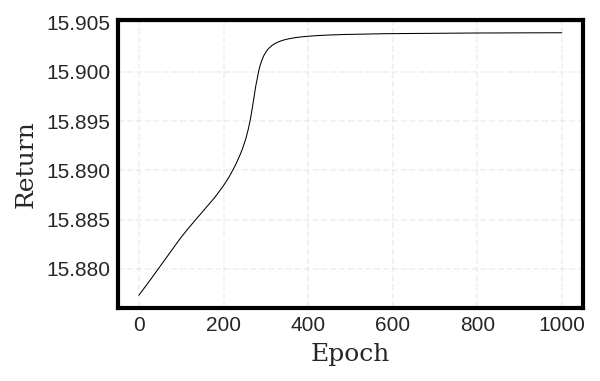

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5), dpi=150)
ax.plot(-np.array(loss_list), lw=0.5, c='k', alpha=1.0)
ax.grid(True, ls='--', alpha=0.3)
ax.set_xlabel('Epoch', fontsize = 12, fontfamily = 'serif')
ax.set_ylabel('Return', fontsize = 12, fontfamily = 'serif')
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('k')
plt.show()

In [21]:
model = LSTMModel(input_size=10, hidden_size=hidden_size, output_size=10, num_layers=num_layers).to(device)
model.load_state_dict(torch.load("/content/gdrive/MyDrive/Portfolio Optimization/LSTM_weights_2.pt"))

<All keys matched successfully>

In [44]:
future = data.shape[0]
returns_lstm = []
pred_weights = []
model.eval()
#start_idx = train_set.shape[0] - window_size
start_idx = 0

for i in range(future):

    seq = data[start_idx+i:start_idx+window_size+i]
    next = data[start_idx+window_size+i:start_idx+window_size+i+1]

    with torch.no_grad():
        pred = model(seq.view(1, -1, 10))
        pred = pred/pred.sum()
        returns = torch.sum(pred*(10**(next-seq[-1])))
        pred_weights.append(pred.cpu().detach().numpy())
        returns_lstm.append(returns.item())
returns_lstm = np.array(returns_lstm)
pred_weights = np.array(pred_weights)

In [46]:
N_guesses = 25

returns_random_guesses = []
pred_weights_random_guesses = []

for j in range(N_guesses):

  returns_random_guess=[]
  pred_weights_random_guess=[]

  for i in range(future):

      seq = data[start_idx+i:start_idx+window_size+i]
      next = data[start_idx+window_size+i:start_idx+window_size+i+1]
      pred = torch.rand(10).to(device)
      pred = pred/pred.sum()
      returns = torch.sum(pred*(10**(next-seq[-1])))
      pred_weights_random_guess.append(pred.cpu().detach().numpy())
      returns_random_guess.append(returns.item())

  returns_random_guesses.append(returns_random_guess)
  pred_weights_random_guesses.append(pred_weights_random_guess)

log_returns_random_guesses = np.array(returns_random_guesses)
pred_weights_random_guesses = np.array(pred_weights_random_guesses)

In [48]:
returns_equal_weights = []

for i in range(future):

    seq = data[start_idx+i:start_idx+window_size+i]
    next = data[start_idx+window_size+i:start_idx+window_size+i+1]
    pred = (torch.ones(10)/10).to(device)
    pred = pred/pred.sum()
    returns = torch.sum(pred*(10**(next-seq[-1])))
    returns_equal_weights.append(returns.item())

returns_equal_weights = np.array(returns_equal_weights)

In [52]:
def movement_history(budget, returns_history):
  out = np.zeros(len(returns_history))
  out[0] = budget
  for i in range(1, len(returns_history)):
    out[i] = out[i-1]*returns_history[i-1]
  return out

movement_history_lstm = movement_history(100, returns_lstm)
movement_history_random_guesses = [movement_history(100, returns_random_guesses[i]) for i in range(N_guesses)]
movement_history_equal_weights = movement_history(100, returns_equal_weights)

In [49]:
mean_pred_weights=pred_weights.reshape((future, 10)).mean(axis=0)

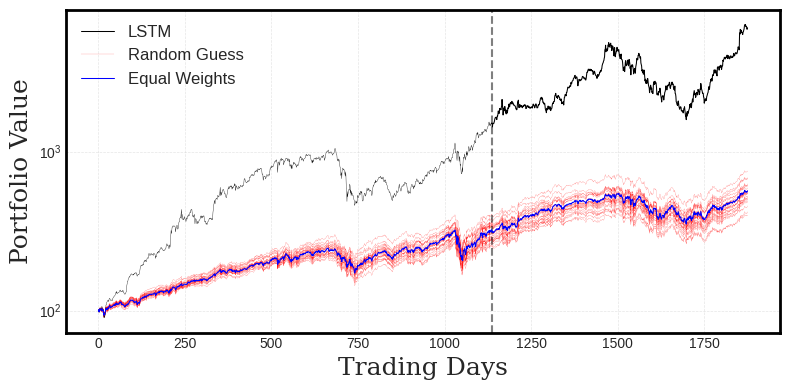

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ts = np.arange(len(returns_lstm))
ax.plot(ts[:-test_size], movement_history_lstm[:-test_size], lw=0.25, c='k')
ax.plot(ts[-test_size:-window_size], movement_history_lstm[-test_size:-window_size], lw=0.75, c='k', label='LSTM')
ax.axvline(x=data.shape[0]-test_size, c='k', ls='--', alpha=0.5)

for i in range(N_guesses):
  rg_plot=ax.plot(ts[:-window_size], movement_history_random_guesses[i][:-window_size], lw=0.1, c='r', zorder=0)
  if i == N_guesses-1:
    rg_plot[0].set_label('Random Guess')

ax.plot(ts[:-window_size], movement_history_equal_weights[:-window_size], lw=0.75, c='b', label='Equal Weights')

''' for i in range(data_np.shape[1]):
    price_history = data_np[start_idx+window_size:start_idx+window_size+future, i]
    movement_history_ticker = np.zeros(len(price_history))
    movement_history_ticker[0] = 100
    for j in range(1, len(price_history)):
        movement_history_ticker[j] = movement_history_ticker[j-1]*(10**(price_history[j]-price_history[j-1]))
    ticker_plot=ax.plot(movement_history_ticker, lw=mean_pred_weights[i]*0.25/(mean_pred_weights.max()), c='gray')
    if np.argmax(mean_pred_weights) == i:
        ticker_plot[0].set_label(tickers[i]+' [w = {:.2f}]'.format(mean_pred_weights[i]))
        ticker_plot[0].set_linewidth(0.75)
        ticker_plot[0].set_color('b') '''

ax.grid(True, ls='--', alpha=0.5, lw=0.5)
ax.set_xlabel('Trading Days', fontsize = 18, fontfamily = 'serif')
ax.set_ylabel('Portfolio Value', fontsize = 18, fontfamily = 'serif')

for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('k')

ax.legend(frameon=False, fontsize=12)
ax.set_yscale('log')

''' ax.set_yticks([50*(2**i) for i in range(8)])
ax.set_yticklabels(['{:d}'.format(k) for k in ax.get_yticks()]) '''


plt.tight_layout()
#plt.savefig('/content/gdrive/MyDrive/Portfolio Optimization/LSTM_plot.png', dpi=300)

plt.show()